In [50]:
import warnings
warnings.filterwarnings('ignore') 

from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

from glime import lime_tabular
import shap
from copy import deepcopy

import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KDTree # new

In [51]:
def rejection_sampling_kde(kde, n_samples):
    var_types = kde.var_type
    continuous_mask = np.array([vt == 'c' for vt in var_types])
    categorical_mask = np.array([vt == 'u' for vt in var_types])

    # Define ranges for continuous data
    min_vals = np.min(kde.data[:, continuous_mask], axis=0)
    max_vals = np.max(kde.data[:, continuous_mask], axis=0)
    
    samples = []
    accepted = 0

    while accepted < n_samples:
        # Generate continuous samples
        cont_samples = np.random.uniform(low=min_vals, high=max_vals)

        # Generate categorical samples for each categorical variable separately
        cat_samples = []
        for cat_index in np.where(categorical_mask)[0]:
            cat_data = kde.data[:, cat_index]
            cat_samples.append(np.random.choice(cat_data))

        # Combine continuous and categorical samples
        sample = np.hstack((cont_samples, cat_samples))

        # Evaluate the density at the sample
        p_sample = kde.pdf(sample)

        # Simplified Q as uniform
        range_prod = np.prod(max_vals - min_vals)  # Product of ranges for continuous data
        q_sample = 1.0 / range_prod  # Assumes a simple uniform distribution for Q

        # Assume some k value (this is an arbitrary example, adjust based on your analysis)
        k = 2

        # Generate a uniform random number for acceptance
        u = np.random.uniform(0, 1)

        if u < p_sample / (k * q_sample):
            samples.append(sample)
            accepted += 1
        # print(accepted)

    return np.array(samples)

In [52]:
def mcmc_sampling_kde(kde, n_samples, burn_in=100, thinning=10):
    var_types = kde.var_type
    continuous_mask = np.array([vt == 'c' for vt in var_types])
    categorical_mask = np.array([vt == 'u' for vt in var_types])

    # Define ranges for continuous data
    min_vals = np.min(kde.data[:, continuous_mask], axis=0)
    max_vals = np.max(kde.data[:, continuous_mask], axis=0)
    
    # Initialize the first sample
    initial_sample = kde.data[0]

    samples = []
    current_sample = initial_sample

    accepted = 0

    while accepted < n_samples * thinning + burn_in:
        # Generate new proposal sample
        proposed_sample = current_sample.copy()

        # Propose changes to continuous variables
        continuous_indices = np.where(continuous_mask)[0]
        for ci in continuous_indices:
            proposed_sample[ci] = np.random.uniform(low=np.min(kde.data[:, ci], axis=0), high=np.max(kde.data[:, ci], axis=0))

        # Propose changes to categorical variables
        categorical_indices = np.where(categorical_mask)[0]
        for ci in categorical_indices:
            cat_data = kde.data[:, ci]
            proposed_sample[ci] = np.random.choice(cat_data)

        # Evaluate the densities
        p_current = kde.pdf(current_sample)
        p_proposed = kde.pdf(proposed_sample)

        # Acceptance probability
        acceptance_prob = min(1, p_proposed / p_current)

        # Generate a uniform random number for acceptance
        u = np.random.uniform(0, 1)

        if u < acceptance_prob:
            current_sample = proposed_sample

        if accepted >= burn_in and (accepted - burn_in) % thinning == 0:
            samples.append(current_sample.copy())

        accepted += 1

    return np.array(samples)


In [55]:
# Get the data set and do some preprocessing
params = Params("model_configurations/experiment_params.json")
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_compas_data(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

categorical_feature_name = ['two_year_recid', 'c_charge_degree_F', 'c_charge_degree_M',\
                            'sex_Female', 'sex_Male', 'race', 'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index('race')
unrelated_indcs = features.index('unrelated_column')
X = X.values

# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

In [56]:
features

['age',
 'two_year_recid',
 'priors_count',
 'length_of_stay',
 'c_charge_degree_F',
 'c_charge_degree_M',
 'sex_Female',
 'sex_Male',
 'race',
 'unrelated_column']

In [57]:
# Fit a KDE model to the training data
kdt = KDTree(xtrain, leaf_size=30, metric='euclidean')
distances, indices = kdt.query(xtrain[0].reshape(1, -1), k=1+100)  # k=11 to include the point itself
data = xtrain[indices[0][1:]]

# Create a KDEMultivariate instance
kde = sm.nonparametric.KDEMultivariate(data=data, var_type='cuccuuuuuu')
# sampled_data = rejection_sampling_kde(kde, 100)
sampled_data = mcmc_sampling_kde(kde, 100)
print("Sampled Data Points:")
print(sampled_data)

Sampled Data Points:
[[-0.66368685  1.10123345 -0.31551452 -0.11113826 -1.33423393  1.33423393
  -0.48516833  0.48516833 -1.03764927 -1.01370374]
 [-0.66368685  1.10123345 -0.31551452 -0.11113826 -1.33423393  1.33423393
  -0.48516833  0.48516833 -1.03764927 -1.01370374]
 [-0.66368685  1.10123345 -0.31551452 -0.11113826 -1.33423393  1.33423393
  -0.48516833  0.48516833 -1.03764927 -1.01370374]
 [-0.66368685  1.10123345 -0.31551452 -0.11113826 -1.33423393  1.33423393
  -0.48516833  0.48516833 -1.03764927 -1.01370374]
 [-0.66368685  1.10123345 -0.31551452 -0.11113826 -1.33423393  1.33423393
  -0.48516833  0.48516833 -1.03764927 -1.01370374]
 [-0.66368685  1.10123345 -0.31551452 -0.11113826 -1.33423393  1.33423393
  -0.48516833  0.48516833 -1.03764927 -1.01370374]
 [-1.02521222 -0.90807267 -0.67758785  0.04949335 -1.33423393 -0.74949376
  -0.48516833  0.48516833  0.96371676  0.98648152]
 [ 0.35105338 -0.90807267  0.1817435   0.08981061 -1.33423393  1.33423393
  -0.48516833  0.48516833  0.9

In [59]:
# Number of observations in the dataset and number of samples to draw
N = 6000
number_samples = 1000

# Generate some sample data
np.random.seed(0)
# Continuous variables: age and income
age = np.random.normal(30, 10, N)  # Average age 30, standard deviation 10
income = np.random.normal(50000, 15000, N)  # Average income 50000, std deviation 15000
# Categorical variables: gender (0 for female, 1 for male), education (0 for highschool, 1 for Bachelor, 2 for Master)
gender = np.random.randint(0, 2, N)  # Randomly assign gender
education = np.random.randint(0, 3, N)  # Randomly assign education level

# Combining all data into a single array
data = np.column_stack((age, income, gender, education))

# Create a KDEMultivariate instance
kde = sm.nonparametric.KDEMultivariate(data=data, var_type='ccuu', bw='normal_reference')

# Use the revised function to sample data
# sampled_data = rejection_sampling_kde(kde, number_samples)
sampled_data = mcmc_sampling_kde(kde, number_samples)
print("Sampled Data Points:")
print(sampled_data)

Sampled Data Points:
[[1.14950545e+01 4.91116713e+04 0.00000000e+00 2.00000000e+00]
 [4.81323209e+01 4.80328827e+04 0.00000000e+00 0.00000000e+00]
 [2.23681719e+01 4.42272779e+04 1.00000000e+00 1.00000000e+00]
 ...
 [2.30977752e+01 6.25339307e+04 1.00000000e+00 1.00000000e+00]
 [3.09422355e+01 2.48213210e+04 0.00000000e+00 1.00000000e+00]
 [2.28354791e+01 5.81791255e+04 1.00000000e+00 2.00000000e+00]]


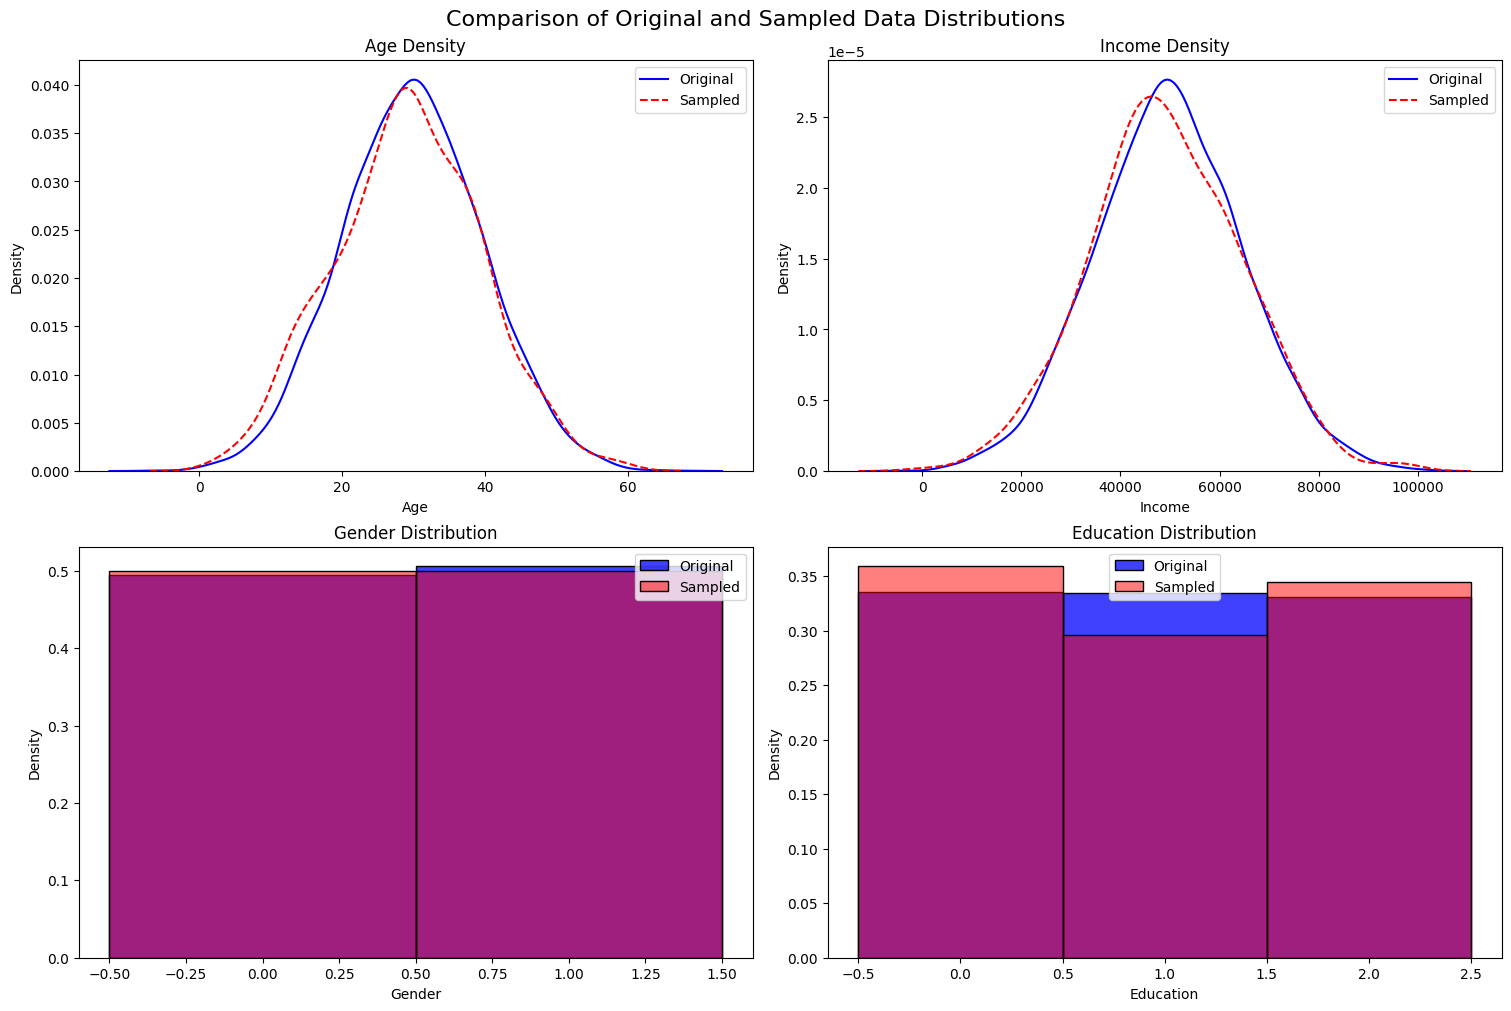

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the original data to a DataFrame for easier manipulation and plotting
original_df = pd.DataFrame(data, columns=['Age', 'Income', 'Gender', 'Education'])
original_df['Gender'] = original_df['Gender'].astype('category')
original_df['Education'] = original_df['Education'].astype('category')

# Convert the sampled data to a DataFrame
sampled_df = pd.DataFrame(sampled_data, columns=['Age', 'Income', 'Gender', 'Education'])
sampled_df['Gender'] = sampled_df['Gender'].astype('category')
sampled_df['Education'] = sampled_df['Education'].astype('category')

# Set up the plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), constrained_layout=True)
fig.suptitle('Comparison of Original and Sampled Data Distributions', fontsize=16)

# Plotting Age density
sns.kdeplot(original_df['Age'], color='blue', ax=axes[0, 0], label='Original')
sns.kdeplot(sampled_df['Age'], color='red', ax=axes[0, 0], label='Sampled', linestyle='--')
axes[0, 0].set_title('Age Density')
axes[0, 0].legend()

# Plotting Income density
sns.kdeplot(original_df['Income'], color='blue', ax=axes[0, 1], label='Original')
sns.kdeplot(sampled_df['Income'], color='red', ax=axes[0, 1], label='Sampled', linestyle='--')
axes[0, 1].set_title('Income Density')
axes[0, 1].legend()

# Categorical plots - Gender distribution
sns.histplot(original_df, x='Gender', stat='density', discrete=True, color='blue', ax=axes[1, 0], label='Original')
sns.histplot(sampled_df, x='Gender', stat='density', discrete=True, color='red', ax=axes[1, 0], label='Sampled', alpha=0.5)
axes[1, 0].set_title('Gender Distribution')
axes[1, 0].legend()

# Categorical plots - Education distribution
sns.histplot(original_df, x='Education', stat='density', discrete=True, color='blue', ax=axes[1, 1], label='Original')
sns.histplot(sampled_df, x='Education', stat='density', discrete=True, color='red', ax=axes[1, 1], label='Sampled', alpha=0.5)
axes[1, 1].set_title('Education Distribution')
axes[1, 1].legend()

plt.show()